# **This notebook aims to study interpretability methods for Survival Gradient Boosting ML**

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Standard ML import
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import OneHotEncoder
import optuna
from itertools import product

# Survival Analysis tools
from sksurv.metrics import concordance_index_censored,cumulative_dynamic_auc,concordance_index_ipcw
from sksurv.metrics import as_concordance_index_ipcw_scorer, as_cumulative_dynamic_auc_scorer, as_integrated_brier_score_scorer
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.datasets import get_x_y
from lifelines import CoxPHFitter
from survlimepy import SurvLimeExplainer

# Interpretability tools

import shap
import lime

# **Read and processing**

In [8]:
# Dataset Insurance
data_ins = pd.read_csv("X_train.csv")
ins_credit = pd.read_csv("y_train.csv")

data_ins.rename(columns = {'0':'age','1':'sex', '2':'smoker', '3':'pren_prod', '4':'pren_comp', '5':'point_sales', '6': 'product_type', '7': 'dist_channel', '8': 'pay_freq', '9': 'pay_method', '10':'profession'}, inplace = True)


# Categorical columns
categorial_columns = ['sex', 'smoker', 'point_sales', 'product_type', 'dist_channel', 'pay_freq', 'pay_method', 'profession']
encoder = OneHotEncoder()
encoder.fit(data_ins[categorial_columns])

ins_encoded = encoder.fit_transform(data_ins[categorial_columns]).toarray()
new_columns = encoder.get_feature_names_out(categorial_columns)
ins_encoded_df = pd.DataFrame(ins_encoded, columns=new_columns)
ins_features = data_ins.drop(columns=categorial_columns).join(ins_encoded_df)

df = pd.concat([ins_features, ins_credit], axis=1).drop(columns=['Unnamed: 0'])

# remove negative time rows
df = df[df['time'] >= 0]

df.head()

,age,pren_prod,pren_comp,sex_0,sex_1,smoker_0,smoker_1,point_sales_0,point_sales_1,point_sales_2,...,pay_freq_2,pay_freq_3,pay_method_0,pay_method_1,pay_method_2,profession_0,profession_1,profession_2,evento,time
0,40,780.00,1.88,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,False,609.0
1,43,52.78,16.88,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,True,757.0
2,52,63.50,0.00,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,True,672.0
3,25,19.10,0.00,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,True,407.0
4,51,351.00,0.00,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,True,632.0


In [9]:
# Data split
X,y = get_x_y(df,attr_labels=['evento','time'],pos_label=1,survival=True)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

# **Cox Model**

In [10]:
# Create Cox model
cox_model = CoxPHFitter()

# Fit the model, for each categorical feature we drop the last category to avoid multicollinearity
cox_model.fit(df.drop(columns=['sex_1','smoker_1','point_sales_4','product_type_10','dist_channel_4','pay_freq_3','pay_method_2','profession_2']), duration_col='time', event_col='evento')

# Display the summary of the model
print(cox_model.summary)

Column pay_freq_2 have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['evento'].astype(bool)
>>> print(df.loc[events, 'pay_freq_2'].var())
>>> print(df.loc[~events, 'pay_freq_2'].var())

A very low variance means that the column pay_freq_2 completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

Newton-Raphson convergence completed successfully but norm(delta) is still high, 0.833. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearity or complete separation in the dataset?



                     coef      exp(coef)     se(coef)  coef lower 95%  \
covariate                                                               
age             -0.016833       0.983308     0.001710       -0.020183   
pren_prod       -0.000066       0.999934     0.000040       -0.000145   
pren_comp        0.000019       1.000019     0.000035       -0.000049   
sex_0            0.051441       1.052787     0.030198       -0.007745   
smoker_0         0.111786       1.118273     0.059501       -0.004834   
point_sales_0   -0.084546       0.918929     0.149576       -0.377710   
point_sales_1    0.219518       1.245477     0.148433       -0.071404   
point_sales_2    0.121547       1.129243     0.155351       -0.182935   
point_sales_3    0.136411       1.146153     0.157423       -0.172131   
product_type_0  13.162454  520452.375289   253.957278     -484.584665   
product_type_1  13.009031  446427.024518   253.957284     -484.738099   
product_type_2  12.813034  366969.526392   253.9572

In [11]:
# c-index of the cox model

c_index = concordance_index_censored(y_train['evento'], y_train['time'], cox_model.predict_expectation(X_train))
print("C-index: ", c_index[0])

C-index:  0.4151557438631665


# **Gradient Boosting Survival Analysis**

In [12]:
# Create and fit the survival svm

SGB = GradientBoostingSurvivalAnalysis(random_state=42)
SGB.fit(X_train,y_train)

GradientBoostingSurvivalAnalysis(random_state=42)

In [13]:
# define the concordance index

def concordance_censored(estimator,X,y):
    concordance = concordance_index_censored([elt[0] for elt in y],[elt[1] for elt in y],estimator.predict(X))
    return concordance[0]

print(f"c_index : {concordance_censored(SGB,X_test,y_test)}")

# define the concordance index ipcw

concordance_ipcw = concordance_index_ipcw(y_train,y_test,SGB.predict(X_test))
print(f"c_index_ipcw : {concordance_ipcw[0]}")

# compute the auc dynamic score

auc_dynamic = cumulative_dynamic_auc(y_train,y_test,SGB.predict(X_test),times = np.arange(1, 2059, 30))
print(f"auc_dynamic : {auc_dynamic[1]}")

c_index : 0.6088186035041973
c_index_ipcw : 0.6072029301052714
auc_dynamic : 0.6322269195865358


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


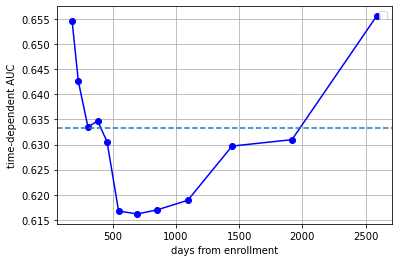

In [14]:
# Plot the time-dependent AUC
times = np.percentile(df['time'], np.linspace(15, 90, 12))
auc, mean_auc = cumulative_dynamic_auc(y_train, y_test, SGB.predict(X_test), times = times)
plt.plot(times, auc, marker="o", color='blue')
plt.xlabel("days from enrollment")
plt.ylabel("time-dependent AUC")
plt.axhline(mean_auc, linestyle="--")
plt.legend()
plt.grid()

# **Hyperparameters optimization**

In [34]:
# Hyperparameters optimization with optuna

# We use the concordance index as evaluation metric
def scorer(estimator, X, y):
    concordance =  concordance_index_censored([elt[0] for elt in y],[elt[1] for elt in y],estimator.predict(X))[0]
    return concordance

def objective(trial):
    # Define search space for hyperparameters
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'random_state': 42
    }
    
    # Initialize model with hyperparameters
    model = GradientBoostingSurvivalAnalysis(**params)
    
    def k_fold_cross_validation(model, X, y, k=5):
        """
        Performs k-fold cross-validation for a given model and dataset.

        Parameters:
            model: The machine learning model to evaluate.
            X (numpy.ndarray): The feature matrix.
            y (numpy.ndarray): The target vector.
            k (int): Number of folds for cross-validation.

        Returns:
            float: The average accuracy across all folds.
        """
        n = len(X)
        fold_size = n // k
        scores = []

        for i in range(k):
            # Splitting data into training and validation sets
            validation_X = X[i * fold_size: (i + 1) * fold_size]
            validation_y = y[i * fold_size: (i + 1) * fold_size]
            train_X = np.concatenate([X[:i * fold_size], X[(i + 1) * fold_size:]])
            train_y = np.concatenate([y[:i * fold_size], y[(i + 1) * fold_size:]])

            # Fitting the model
            model.fit(train_X, train_y)

            # Making predictions on the validation set
            y_pred = model.predict(validation_X)

            # Calculating accuracy
            score = scorer(model, validation_X, validation_y)
            scores.append(score)

        # Returning the average accuracy
        return sum(scores) / k
    
    return k_fold_cross_validation(model, X_train, y_train, k=5)

# Create Optuna study object
study = optuna.create_study(direction='maximize')

# Run optimization
study.optimize(objective, n_trials=10)

# Access best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

[I 2024-04-18 14:03:59,026] A new study created in memory with name: no-name-6666526c-cd2d-4151-9b30-dcc3214b2a86
X has feature names, but GradientBoostingSurvivalAnalysis was fitted without feature names
X has feature names, but GradientBoostingSurvivalAnalysis was fitted without feature names
X has feature names, but GradientBoostingSurvivalAnalysis was fitted without feature names
X has feature names, but GradientBoostingSurvivalAnalysis was fitted without feature names
X has feature names, but GradientBoostingSurvivalAnalysis was fitted without feature names
X has feature names, but GradientBoostingSurvivalAnalysis was fitted without feature names
X has feature names, but GradientBoostingSurvivalAnalysis was fitted without feature names
X has feature names, but GradientBoostingSurvivalAnalysis was fitted without feature names


In [ ]:
# Hyperparameters optimization with a gridsearch approach, we use a gridsearch suggested by the optuna optimization

# Define the gridsearch space
param_grid = {'n_estimators': [231, 232, 233, 234, 235],
              'learning_rate': [0.051, 0.054, 0.06, 0.05774248],
              'subsample': [0.62,0.631222,0.64],
              'max_depth': [3, 4, 2],
              'min_samples_split': [19, 20, 21],
              'min_samples_leaf': [11, 12, 13]}

param_comb = list(product(*(param_grid[param] for param in param_grid.keys())))

# Initialize the model
best_score = 0
best_params = None

for comb in param_comb : 
    # Create model instance with current hyperparameters
    model = GradientBoostingSurvivalAnalysis(n_estimators=comb[0], learning_rate=comb[1], subsample=comb[2], max_depth=comb[3], min_samples_split = comb[4], min_samples_leaf = comb[5], random_state = 42)
    
    def k_fold_cross_validation(model, X, y, k=5):
        """
        Performs k-fold cross-validation for a given model and dataset.

        Parameters:
            model: The machine learning model to evaluate.
            X (numpy.ndarray): The feature matrix.
            y (numpy.ndarray): The target vector.
            k (int): Number of folds for cross-validation.

        Returns:
            float: The average accuracy across all folds.
        """
        n = len(X)
        fold_size = n // k
        scores = []

        for i in range(k):
            # Splitting data into training and validation sets
            validation_X = X[i * fold_size: (i + 1) * fold_size]
            validation_y = y[i * fold_size: (i + 1) * fold_size]
            train_X = np.concatenate([X[:i * fold_size], X[(i + 1) * fold_size:]])
            train_y = np.concatenate([y[:i * fold_size], y[(i + 1) * fold_size:]])

            # Fitting the model
            model.fit(train_X, train_y)

            # Making predictions on the validation set
            y_pred = model.predict(validation_X)

            # Calculating accuracy
            score = scorer(model, validation_X, validation_y)
            scores.append(score)
            
        # Returning the average accuracy
        return sum(scores) / k
    
    if k_fold_cross_validation(model, X_train, y_train, k=5)>best_score:
        best_score = k_fold_cross_validation(model, X_train, y_train, k=5)
        best_params = {'n_estimators':comb[0], 'learning_rate':comb[1], 'subsample':comb[2], 'max_depth':comb[3], 'min_samples_split' : comb[4], 'min_samples_leaf': comb[5], 'random_state' : 42}

print("Best Hyperparameters:", best_params)
print("Best Score:", best_score)

In [ ]:
# Best GradientBoostingSurvivalAnalysis model

best_SGB = GradientBoostingSurvivalAnalysis(**best_params)
best_SGB.fit(X_train, y_train)

# Compute the concordance index

print(f"c_index : {concordance_censored(best_SGB,X_test,y_test)}")

## Optimising hyperparameters according to metrics

In [ ]:
cv = KFold(n_splits=5, shuffle=True, random_state=1)

cv_param_grid = {
    "estimator__max_depth": np.arange(1, 10, dtype=int),
}

In [ ]:
gcv_cindex = GridSearchCV(
    as_concordance_index_ipcw_scorer(best_SGB, tau=times[-1]),
    param_grid=cv_param_grid,
    cv=cv,
    n_jobs=4,
).fit(X_train, y_train)

In [ ]:
gcv_iauc = GridSearchCV(
    as_cumulative_dynamic_auc_scorer(best_SGB, times=times),
    param_grid=cv_param_grid,
    cv=cv,
    n_jobs=4,
).fit(X_train, y_train)

In [ ]:
gcv_ibs = GridSearchCV(
    as_integrated_brier_score_scorer(best_SGB, times=times),
    param_grid=cv_param_grid,
    cv=cv,
    n_jobs=4,
).fit(X_train, y_train)

In [ ]:
def plot_grid_search_results(gcv, ax, name):
    ax.errorbar(
        x=gcv.cv_results_["param_estimator__max_depth"].filled(),
        y=gcv.cv_results_["mean_test_score"],
        yerr=gcv.cv_results_["std_test_score"],
    )
    ax.plot(
        gcv.best_params_["estimator__max_depth"],
        gcv.best_score_,
        "ro",
    )
    ax.set_ylabel(name)
    ax.yaxis.grid(True)


_, axs = plt.subplots(3, 1, figsize=(6, 6), sharex=True)
axs[-1].set_xlabel("max_depth")

plot_grid_search_results(gcv_cindex, axs[0], "c-index")
plot_grid_search_results(gcv_iauc, axs[1], "iAUC")
plot_grid_search_results(gcv_ibs, axs[2], "$-$IBS")

# **Interpretability methods**

# RVI

In [ ]:
feature_importances = best_SGB.feature_importances_

total_importance = np.sum(feature_importances)
importances_percentage = (feature_importances / total_importance) * 100
importances_percentage.sort()
variable_names = X_train.columns

plt.figure(figsize=(10, 6))
plt.barh(range(len(importances_percentage)), importances_percentage, tick_label=variable_names)
plt.xlabel('Importance en pourcentage')
plt.ylabel('Variables')
plt.title('Importance des variables')
plt.show()

# SurvLIME

In [ ]:
# define explainer for the best model
explainer_gb = SurvLimeExplainer(
    training_features=X_train,
    training_events=[tp[0] for tp in y_train],
    training_times=[tp[1] for tp in y_train],
    model_output_times=best_SGB.event_times_,
    random_state=42,
)


In [ ]:
# plot feature importance
explainer_gb.plot_weights()

In [ ]:
# select instance to explain
instance_index = 0

# explain one instance
b_gb = explainer_gb.explain_instance(
    data_row = X_test.iloc[instance_index].values,
    predict_fn=best_SGB.predict_cumulative_hazard_function,
    num_samples=1000,
    verbose=False,
)

In [ ]:
# create a dictionary that maps the feature names to lime feature coefficient

feature_names = X_train.columns
feature_dict = {}
for i in range(len(feature_names)):
    feature_dict[feature_names[i]] = b_gb[i]

feature_dict

# SHAP

In [ ]:
# Let's use shap method to interpret this model, since the output of a SSVM is a risk score, we can use classical shap method to interpret it

# use Tree Explainer SHAP to explain test set predictions
explainer = shap.Explainer(best_SGB.predict, X_train)
shap_values = explainer.shap_values(X_test)

In [ ]:
shap.summary_plot(shap_values,X_test)

shap.dependence_plot("enum", shap_values, X_test)